In [1]:
# Import libraries -----------------------------

import csv
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
import string
from nltk.corpus import stopwords as sw
from nltk.stem.snowball import ItalianStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import IncrementalPCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
# Define some global variables ------------------

punctuation = string.punctuation + '\n'
stopwords = sw.words('italian')
# Remove some useful words from stopwords
stopwords.remove('non') #not
stopwords.remove('sono') #am
stopwords.remove("ma") #but
stopwords.remove('contro') #cons

In [3]:
# Define functions -----------------------------

def preprocessing(texts):
    prep_texts = []
    regex = re.compile('[%s]' % re.escape(punctuation))
    for text in texts:
        # Remove numbers
        text = re.sub(r'\d+', ' ', text)
        # Remove foreign chars
        text = re.sub(r'[^a-zA-ZàèéìíîòóùúÀÈÉÌÍÎÒÓÙÚ]', ' ', text)
        # remove all the special characters
        text = re.sub(r'\W', ' ', text)
        # Remove punctuation
        text = regex.sub(" ", text)
        # Remove characters length equal to 1
        text = re.sub(r"\b[a-zA-Zèé]\b", "", text)
        # Remove whitespaces
        text = text.strip()
        # Convert text to lowercase
        text = text.lower()
        prep_texts.append(text)
    return prep_texts


def count_words(texts):
    words = set()
    for row in texts:
        words.update(row.split())
    return len(words)


def top_n_words_occur(texts, n):
    final_text = " ".join(texts)
    word_counter = Counter(final_text.split())
    return word_counter.most_common(n)  # return a list of tuples


def divide_dev_pos_neg(texts):
    pos_reviews = []
    neg_reviews = []
    for i in range(len(dev_texts)):
        if dev_classes[i] == 'pos':
            pos_reviews.append(texts[i])
        else:
            neg_reviews.append(texts[i])
    return pos_reviews, neg_reviews

def bar_chart(list):
    height = [h[1] for h in list[:10]]
    print(height)
    x = np.arange(10)
    labels = [l[0] for l in list[:10]]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(x, height, tick_label=labels)
    plt.show()


def tokenization(reviews):
    tokens = []
    stemmer = ItalianStemmer()
    for review in reviews:
        t = word_tokenize(review, language='italian')
        result = [stemmer.stem(word) for word in t if ((word not in stopwords)
                  and (len(word) > 1) and len(word) < 18)]
        str_result = " ".join(result)
        tokens.append(str_result)
    return tokens


# Map classes to int (0, 1)

def map_classes(labels):
    y_truth = []
    for dc in labels:
        if dc == "pos":
            y_truth.append(0)
        elif dc == "neg":
            y_truth.append(1)
    return y_truth

List of reviews len = 28754
List of lebes len = 28754
Correct: two lists have the same length
Number of textual reviews in development.csv = 28754
Number of textual reviews in evaluation.csv = 12323
There are 19532 positive reviews in development.csv -> 67.93% of dataset
There are 9222 positive reviews in development.csv -> 32.07% of dataset


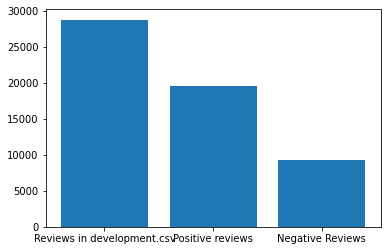

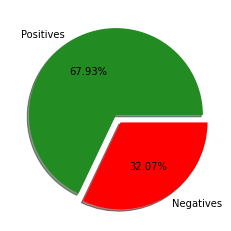

Number of total words in development.csv = 20168966
Number of different words in development.csv = 153276
Number of different words in positive reviews = 97103
Number of different words in negative reviews = 92737


In [4]:
# Load data and Data exploration --------------------------

# I choose to import data from csv file and save them in 2 lists

dev_texts, dev_classes = [], []
eval_texts = []

with open('Datasets/development.csv', mode='r', encoding='utf-8') as dev_fp:
    dev_reader = csv.reader(dev_fp)
    columns = next(dev_reader)
    for row in dev_reader:
        if row[0] != "" and (row[1] == 'pos' or row[1] == 'neg'):
            dev_texts.append(row[0])
            dev_classes.append(row[1])

# Check for the length

print("List of reviews len =", len(dev_texts))
print("List of lebes len =", len(dev_classes))

if len(dev_texts) == len(dev_classes):
    print("Correct: two lists have the same length")
else:
    sys.exit("Error: two lists have not the same length")

y = map_classes(dev_classes)

texts = pd.Series(dev_texts)
classes = pd.Series(dev_classes)

df = pd.DataFrame({columns[0]: texts, columns[1]: classes})

with open('Datasets/evaluation.csv', mode='r', encoding='utf-8') as eval_fp:
    eval_reader = csv.reader(eval_fp)
    next(eval_reader)
    for row in eval_reader:
        eval_texts.append(row[0])

print("Number of textual reviews in development.csv =", df.shape[0])
print("Number of textual reviews in evaluation.csv =", len(eval_texts))

mask_p = df['class'] == 'pos'
mask_n = df['class'] == 'neg'

t_pos = df[mask_p].count()[0]
t_neg = df[mask_n].count()[0]

print(f"There are {t_pos} positive reviews in development.csv -> {t_pos/df.shape[0]*100:.2f}% of dataset")
print(f"There are {t_neg} positive reviews in development.csv -> {t_neg/df.shape[0]*100:.2f}% of dataset")

# Plot a bar chart

height = [df.shape[0], t_pos, t_neg]
x = [1, 2, 3]
bar_labels = ['Reviews in development.csv', 'Positive reviews', 'Negative Reviews']

bar_fig, bar_ax = plt.subplots()
bar_ax.bar(x, height, tick_label=bar_labels)
plt.show()

# Plot a pie

pie = plt.pie([t_pos, t_neg], labels=["Positives", "Negatives"], colors=['forestgreen', 'red'], autopct='%1.2f%%', explode=(0, 0.1), shadow=True, startangle=0)
plt.show()

# Statistics from dataset
dev_all_words = count_words(df['text'])
dev_pos_words = count_words(df.loc[mask_p, 'text'])
dev_neg_words = count_words(df.loc[mask_n, 'text'])

tot_words = 0
for str in df['text']:
    tot_words+=len(str)

print("Number of total words in development.csv =", tot_words)
print("Number of different words in development.csv =", dev_all_words)
print("Number of different words in positive reviews =", dev_pos_words)
print("Number of different words in negative reviews =", dev_neg_words)

In [5]:
# Data Preprocessing ---------------------------------------------

preproc_dev_texts = preprocessing(df['text'])
preproc_eval_texts = preprocessing(eval_texts)



1 - Analysis of data after first step of preprocessing


There are 52890 different words in development.csv

Top 10 words in all texts:
[('di', 87510), ('la', 78396), ('il', 67318), ('un', 58874), ('per', 56039), ('che', 54484), ('in', 52708), ('non', 42637), ('hotel', 37676), ('una', 37556)] 

[87510, 78396, 67318, 58874, 56039, 54484, 52708, 42637, 37676, 37556]


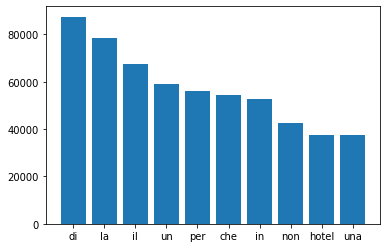

[51906, 47092, 41093, 36336, 33599, 31071, 27062, 25407, 23266, 22541]


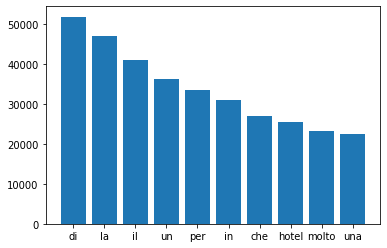

[35604, 31304, 27422, 26225, 25960, 22538, 22440, 21637, 15015, 13828]


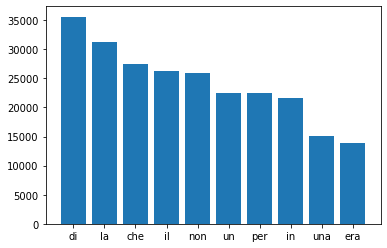

Top 15 words in positive reviews:
[('di', 51906), ('la', 47092), ('il', 41093), ('un', 36336), ('per', 33599), ('in', 31071), ('che', 27062), ('hotel', 25407), ('molto', 23266), ('una', 22541)] 

Top 15 words in negative reviews:
[('di', 35604), ('la', 31304), ('che', 27422), ('il', 26225), ('non', 25960), ('un', 22538), ('per', 22440), ('in', 21637), ('una', 15015), ('era', 13828)] 



In [6]:
# First data Analysis --------------------------------------------

print("\n\n1 - Analysis of data after first step of preprocessing\n\n")

all_preproc_dev_words = count_words(preproc_dev_texts)

print("There are", all_preproc_dev_words, "different words in development.csv\n")

all_most_preproc_occur = top_n_words_occur(preproc_dev_texts, 10)

print("Top 10 words in all texts:")
print(all_most_preproc_occur, "\n")

# Plot a bar char of all best words

bar_chart(all_most_preproc_occur)

# Divide in positive and negative reviews

preproc_dev_pos_reviews, preproc_dev_neg_reviews = divide_dev_pos_neg(preproc_dev_texts)

all_most_pos_occur = top_n_words_occur(preproc_dev_pos_reviews, 10)
all_most_neg_occur = top_n_words_occur(preproc_dev_neg_reviews, 10)

# Plot a bar chart of positive words
bar_chart(all_most_pos_occur)

# Plot a bar char of negative words
bar_chart(all_most_neg_occur)

print("Top 15 words in positive reviews:")
print(all_most_pos_occur, '\n')
print("Top 15 words in negative reviews:")
print(all_most_neg_occur, '\n')



2 - Analysis of data after first step of preprocessing


There are 27207 different tokens in development.csv
Top 10 words in all texts:
[('non', 42666), ('hotel', 37676), ('molt', 32691), ('ma', 24106), ('camer', 22473), ('son', 20234), ('stat', 19246), ('colazion', 18081), ('personal', 18062), ('ottim', 11532)] 

[42666, 37676, 32691, 24106, 22473, 20234, 19246, 18081, 18062, 11532]


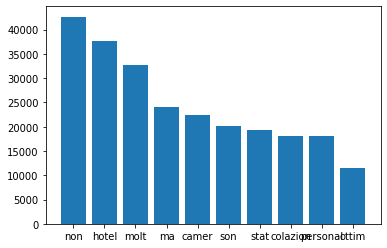

Top 10 words in positive reviews:
[('hotel', 25407), ('molt', 24841), ('non', 16693), ('personal', 13448), ('ma', 13169), ('colazion', 12770), ('son', 12185), ('camer', 12084), ('stat', 11127), ('ottim', 10476)] 

Top 10 words in negative reviews:
[('non', 25973), ('hotel', 12269), ('ma', 10937), ('camer', 10389), ('stat', 8119), ('son', 8049), ('molt', 7850), ('colazion', 5311), ('cos', 5050), ('sol', 4759)] 



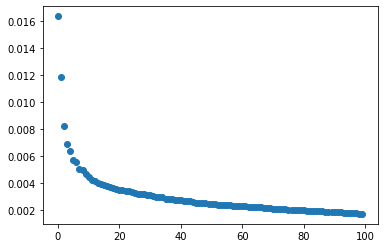

/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Accuracy of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') is 0.8332463919318379
Confusion Matrix of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') is [[3450  462]
 [ 497 1342]]


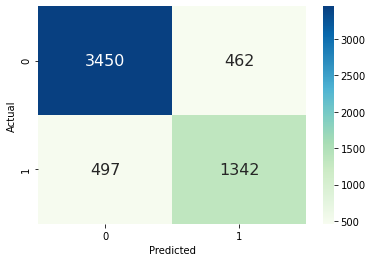

/usr/lib/python3/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/stoc

Accuracy of SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False) is 0.9469657450878108
Confusion Matrix of SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False) is [[3793  119]
 [ 186 1653]]


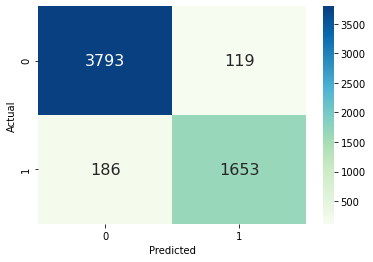

Accuracy of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) is 0.894453138584594
Confusion Matrix of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) is [[3790  122]
 [ 485 1354]]


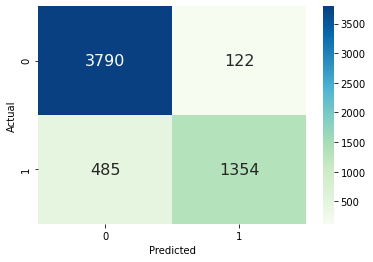

Accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) is 0.945226917057903
Confusion Matrix of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) is [[3770  142]
 [ 173 1666]]


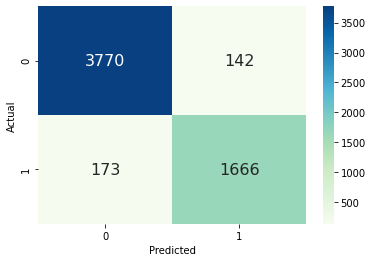

In [8]:
# Second data analysis ----------------------------------

# Tokenization

dev_token_list = tokenization(preproc_dev_texts)
eval_token_list = tokenization(preproc_eval_texts)

print("\n\n2 - Analysis of data after first step of preprocessing\n\n")

# Count different words

diff_words = count_words(dev_token_list)

print("There are", diff_words, "different tokens in development.csv")

all_most_final_occur = top_n_words_occur(dev_token_list, 10)

print("Top 10 words in all texts:")
print(all_most_final_occur, "\n")

bar_chart(all_most_final_occur)

final_dev_pos_reviews, final_dev_neg_reviews = divide_dev_pos_neg(dev_token_list)

final_pos_occur = top_n_words_occur(final_dev_pos_reviews, 10)
final_neg_occur = top_n_words_occur(final_dev_neg_reviews, 10)

print("Top 10 words in positive reviews:")
print(final_pos_occur, '\n')
print("Top 10 words in negative reviews:")
print(final_neg_occur, '\n')

# Create a vector of TfidfVectorizer with many configurations -------------

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
X = vectorizer.fit_transform(dev_token_list)
pca = IncrementalPCA(n_components=100)
X_projection = pca.fit_transform(X.toarray())
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='')
plt.show()

# from the plot we find that n_components is 10 more or less

n = 10
pca = IncrementalPCA(n_components=n)
#X_projection = pca.fit_transform(X.toarray())

### Search for best model with best params ------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

clfs = []
all_params = []

# Add DecisionTree

clfs.append(DecisionTreeClassifier())
param_grid_DT = {
    'criterion' : ['gini', 'entropy'],
    'spltter' : ['best', 'random'],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'random_state' : [42],
    'class_weight' : [{0: 68, 1: 32}]
}
all_params.append(param_grid_DT)

# Add SGDClassifier
clfs.append(SGDClassifier())
param_grid_SGD = {
    #'alpha' : ['optimal']
    'tol': [1e-10, 1e-7, 1e-5, 1e-3],
    'n_jobs': [-1]
}
all_params.append(param_grid_SGD)

# Add Random Forests

clfs.append(RandomForestClassifier())
param_grid_RF = {
    'n_estimators':[10, 50, 100],
    'n_jobs': [-1]
}
all_params.append(param_grid_RF)

# Add LinearSVC

clfs.append(LinearSVC())
param_grid_SVC = {
    'tol': [1e-11, 1e-10, 1e-8, 1e-6, 1e-4],
    'C': [0.5, 1, 3, 5],
}
all_params.append(param_grid_SVC)

### Algorithm choice --------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

for clf in clfs:
    clf.fit(X_train, y_train)
    y_pred = cross_val_predict(clf, X_test, y_test, cv=10)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s"%(clf, acc))
    
    # Print the confusion matrix
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is %s"%(clf, cm))
    conf_mat_df = pd.DataFrame(cm)
    conf_mat_df.index.name = 'Actual'
    conf_mat_df.columns.name = 'Predicted'
    sns.heatmap(conf_mat_df, annot=True, cmap='GnBu', annot_kws={"size":16}, fmt='g')
    plt.show()